**Note:** 
Follow these steps to ensure cmdstan runs.
1. Create an environment with all of the packages below:
   `pip install altair arviz numpy pandas plotnine matplotlib cmstanpy`
2. Install cmdstan using the `install_cmdstan()` command in the activated environment.

If you do not care about environments and just run it globally then it will also work.

In [5]:
#import altair as alt
#import arviz as az
import numpy as np
import pandas as pd
#import plotnine as p9
import matplotlib.pyplot as plt
#import cmdstanpy
#from cmdstanpy import CmdStanModel

# Loading and preprocessing of data
The following data of glucose, lactate, glutamine, and glutamate concentrations was
collected using the Flex. The cell diameter and count was determined using the Nucleocounter.
Becuase the concentration measurements were collected throughout addition and removal of 
liquid we need to adjust this concentration to an abstract concentration that can be fitted 
using a linear regression.

In [6]:
data = pd.read_excel("Timecourse.xlsx")
reactor_strain_map = {"1": 1,"2": 1,"3": 1,"4": 1,"5": 2,"6": 2,"7": 2,"8": 2}
strains = {1: "CHO-S wt", 2: "CHO-ZeLa"}
calculated_dilution_ratio = 1.075 # Accounting for the dilution from the glucose spike
columns = ["Sample ID", "Gln", "Glu", "Gluc", "Lac", "Live (cells/ml)", "Dead (cells/ml)", "Estimated cell diameter (um)", "time", "Ala", "Pyr", "sample_point"]
data["Ala"] = data["Alanine Amount (mM) (Acounting 20x diluted)"]
data["Pyr"] = data["Pyr Amount (mM)"]
data["sample_point"] = data["Sample ID"].apply(lambda x: int(x.split(" ")[1][-1]))
data = data[columns]
adjust_columns=["Gln", "Glu", "Gluc", "Lac", "Live (cells/ml)", "Dead (cells/ml)", "Ala", "Pyr"]
# Adjust for dilution
data.loc[data["sample_point"]>2,adjust_columns] = data.loc[data["sample_point"]>2][adjust_columns]*calculated_dilution_ratio
# Adjust for component addition
## concentration of added glucose
glucose_spike = 231 * (0.001/0.01435) # C_added = C_spike*(V_spike/V_reactor_after_spike)
glutamine_spike = 46 * (0.001/0.01435) # C_added = C_spike*(V_spike/V_reactor_after_spike)
data.loc[data["sample_point"]<=2, "Gluc"] = data.loc[data["sample_point"]<=2]["Gluc"] + glucose_spike
data.loc[data["sample_point"]<=2, "Gln"] = data.loc[data["sample_point"]<=2]["Gln"] + glutamine_spike
# Remove sample point 3 as to not have to deal with non-ragged data.
data = data.loc[data["sample_point"]!=3]
# Calculating volume parmaeters
data["volume (L/ml)"] = data.apply(lambda x: x["Live (cells/ml)"]*4/3*np.pi*(x["Estimated cell diameter (um)"]/2/1000000)**3*1000, axis=1)
data["ln_volume"] = np.log(data["volume (L/ml)"])
data["ln_cell_count"] = np.log(data["Live (cells/ml)"])
# mapping samples to reactor/strain
data["reactor"] = data["Sample ID"].apply(lambda x: x.split(" ")[0].split("-")[1])
data["strain"] = data["reactor"].map(reactor_strain_map)
data=data[data["time"]>0] # Excluding the first timepoint due to potential strange behaviour when innoculated into bioreactors

In [7]:
data

,Sample ID,Gln,Glu,Gluc,Lac,Live (cells/ml),Dead (cells/ml),Estimated cell diameter (um),time,Ala,Pyr,sample_point,volume (L/ml),ln_volume,ln_cell_count,reactor,strain
8,cs1-1 p1,6.005575,1.6000,41.297561,4.49000,1180000,81600,13.4,24,0.684140,0.447900,1,0.000001,-13.419017,13.981025,1,1
9,cs1-2 p1,5.905575,1.7000,40.997561,4.84000,1360000,86800,13.3,24,0.704232,0.559800,1,0.000002,-13.299519,14.122995,2,1
10,cs1-3 p1,6.005575,1.6000,41.497561,4.33000,1330000,78800,13.3,24,0.667303,0.428400,1,0.000002,-13.321824,14.100690,3,1
11,cs1-4 p1,6.005575,1.5000,41.697561,4.18000,1420000,80200,13.5,24,0.671007,0.408000,1,0.000002,-13.211569,14.166167,4,1
12,cs1-5 p1,6.305575,1.5000,43.197561,0.48000,1480000,84500,13.4,24,0.793377,1.348500,1,0.000002,-13.192489,14.207553,5,2
13,cs1-6 p1,6.205575,1.6000,43.097561,0.51000,1350000,132000,13.5,24,0.871074,1.480200,1,0.000002,-13.262122,14.115615,6,2
14,cs1-7 p1,6.305575,1.5000,43.497561,0.51000,1320000,90600,13.6,24,0.735548,1.236900,1,0.000002,-13.262454,14.093142,7,2
15,cs1-8 p1,6.405575,1.5000,43.297561,0.52000,1330000,94400,13.8,24,0.716399,1.279500,1,0.000002,-13.211111,14.100690,8,2
16,cs1-1 p2,4.105575,1.8000,36.297561,8.98000,3140000,139000,13.3,44,1.447413,0.519300,2,0.000004,-12.462781,14.959733,1,1
17,cs1-2 p2,4.105575,1.9000,34.897561,10.70000,2950000,149000,13.4,44,1.581704,0.596700,2,0.000004,-12.502726,14.897316,2,1


# Statistical Model
We consider each reactor as an observation of the "true" cell line behaviour with the observed parameters 
for growth. This is described in the following expressions
$$ \mu_{reactor} \sim Normal(\mu_{strain}, \sigma_{\mu, cell})$$
$$ \hat{\mu}_{reactor} \sim Normal(\mu_{reactor}, \sigma_{\mu, reac})$$

$$ Y_{reactor} \sim Normal(Y_{strain}, \sigma_{Y, cell})$$
$$ \hat{Y}_{reactor} \sim Normal(Y_{reactor}, \sigma_{Y, reac})$$

We assume that the growth rate of the cells are exponential and can therefore consider the 
biomass to be determined by the following linear model

$$ X_t = X_0 + \mu * t$$

where t, is the time after incubation, and X is the biomass.

The calculated quantity in this model is the yield (Y) for products and substrates, 
for a given timepoint we calculate the concentration of the substrates or products by
the following

$$S_t = S_0 - Y_{SX} \times (X_t - X_0)$$
$$P_t = P_0 + Y_{PX} \times (X_t - X_0)$$

The previous equations imply there is a relationship between the growth rate (used in $X_t$) and the yield (Y),
therefore, we cannot use the marginal esimates of each parameter to determine the specific uptake and production 
rates. The specific uptake and production rates are determined using the joint distribution of the yield and growth
rate and are calculated using 

$$q = Y \times \mu$$

To make statements surrounding the cell line we will use the cell line specific parameters

$$q_{strain} = Y_{strain} \times \mu_{strain}$$

In [8]:
model = CmdStanModel(stan_file="yield_growth_rate.stan")

NameError: name 'CmdStanModel' is not defined

## Sampling Model
Occasionally fails when it cannot find the correct region. Restarting appears to remove any divergences/lack of convergence.

In [9]:
substrates = ["Gluc"]
products = ["Lac", "Ala", "Pyr"]
model_input = {
    "N_sub": len(substrates),
    "N_prod": len(products),
    "N_reactor": len(data["reactor"].unique()),
    "N_strain": len(data["strain"].unique()),
    "M": data.shape[0],
    "reactor": data["reactor"].astype(int),
    "strain":list(reactor_strain_map.values()),
    "X_m": data["ln_volume"],
    "S_m": data[substrates],
    "P_m": data[products],
    "t": data["time"]
}
pf = model.pathfinder(
    data = model_input,
    inits={
        "S_0":[[50,50,50,50,50,50,50,50]], 
        "P_0":[[20,20,20,20,20,20,20,20], [50,50,50,50,50,50,50,50], [50,50,50,50,50,50,50,50]],
    }
)
fit = model.sample(
    data = model_input,
    chains=2,
    inits=pf.create_inits(),
    parallel_chains=2,
    iter_warmup=2000,
    iter_sampling=1000,
    max_treedepth=13,
    adapt_delta=0.999,
)
coords = {
    "substrate": substrates,
    "product": products,
    "reactor": data["reactor"].astype(int).unique(),
    "strain": list(strains.values()),
    "time": data["time"],
}
dims = {
    "mu": ["reactor"],
    "Ys": ["substrate", "reactor"],
    "Yp": ["product", "reactor"],
    "mu_s": ["strain"],
    "Ys_s": ["substrate", "strain"],
    "Yp_s": ["product", "strain"],
    "uptake_rates": ["substrate", "strain"],
    "production_rates": ["product", "strain"],
}
idata = az.from_cmdstanpy(fit, coords=coords, dims=dims)

NameError: name 'model' is not defined

In [10]:
fit.diagnose()

NameError: name 'fit' is not defined

## Statistical analysis
Diagnostics are all satisfactory:
- didn't exhause treedepth,
- no divergent transitions,
- R-hat values are all satisfactory.

This indicates that the MCMC sampling was convergent and resulted in an adequate exploration of the parameter space

In [304]:
growth_data = idata.posterior.mu_s.to_dataframe().reset_index()
uptake_rates = idata.posterior.uptake_rates.to_dataframe().reset_index()
production_rates = idata.posterior.production_rates.to_dataframe().reset_index()

summary_data_flat = pd.DataFrame(columns=["par", "stat", "strain", "value"])
count = 0
for strain in strains.values():
    # Growthrate
    summary_data_flat.loc[count, "par"] = "growth rate [1/h]"
    summary_data_flat.loc[count, "stat"] = "lower bound (2.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = growth_data[["strain", "mu_s"]].groupby(["strain"]).quantile(0.025).loc[strain][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "growth rate [1/h]"
    summary_data_flat.loc[count, "stat"] = "upper bound (97.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = growth_data[["strain", "mu_s"]].groupby(["strain"]).quantile(0.975).loc[strain][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "growth rate [1/h]"
    summary_data_flat.loc[count, "stat"] = "mean"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = growth_data[["strain", "mu_s"]].groupby(["strain"]).mean().loc[strain][0]
    count += 1
    # Glucose uptake rate
    summary_data_flat.loc[count, "par"] = "glucose uptake rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "lower bound (2.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = uptake_rates[["substrate", "strain", "uptake_rates"]].groupby(["strain", "substrate"]).quantile(0.025).loc[strain].loc["Gluc"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "glucose uptake rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "upper bound (97.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = uptake_rates[["substrate", "strain", "uptake_rates"]].groupby(["strain", "substrate"]).quantile(0.975).loc[strain].loc["Gluc"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "glucose uptake rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "mean"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = uptake_rates[["substrate", "strain", "uptake_rates"]].groupby(["strain", "substrate"]).mean().loc[strain].loc["Gluc"][0]
    count += 1
    # Lactate production rate
    summary_data_flat.loc[count, "par"] = "lactate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "lower bound (2.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.025).loc[strain].loc["Lac"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "lactate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "upper bound (97.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.975).loc[strain].loc["Lac"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "lactate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "mean"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).mean().loc[strain].loc["Lac"][0]
    count += 1
    # Alanine production rate
    summary_data_flat.loc[count, "par"] = "alanine production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "lower bound (2.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.025).loc[strain].loc["Ala"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "alanine production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "upper bound (97.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.975).loc[strain].loc["Ala"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "alanine production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "mean"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).mean().loc[strain].loc["Ala"][0]
    count += 1
    # Pyruvate production rate
    summary_data_flat.loc[count, "par"] = "pyruvate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "lower bound (2.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.025).loc[strain].loc["Pyr"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "pyruvate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "upper bound (97.5%)"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).quantile(0.975).loc[strain].loc["Pyr"][0]
    count += 1
    summary_data_flat.loc[count, "par"] = "pyruvate production rate [mol/mLcell/h]"
    summary_data_flat.loc[count, "stat"] = "mean"
    summary_data_flat.loc[count, "strain"] = strain
    summary_data_flat.loc[count, "value"] = production_rates[["product", "strain", "production_rates"]].groupby(["strain", "product"]).mean().loc[strain].loc["Pyr"][0]
    count += 1

/var/folders/dg/rm_5w1r54719cfv7q8cj0nkjnz2j8q/T/ipykernel_25890/1840016846.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/dg/rm_5w1r54719cfv7q8cj0nkjnz2j8q/T/ipykernel_25890/1840016846.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/dg/rm_5w1r54719cfv7q8cj0nkjnz2j8q/T/ipykernel_25890/1840016846.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
/var/folders/dg/rm_5w1r54719cfv7q8cj0nkjnz2j8q/T/ipyker

## Summary Table

In [305]:
summary_data_flat.pivot(index=["stat"], columns=["strain", "par"])

value                                     \
strain                       CHO-S wt                                      
par                 growth rate [1/h] glucose uptake rate [mol/mLcell/h]   
stat                                                                       
lower bound (2.5%)           0.035189                           0.060357   
mean                         0.038708                           0.074231   
upper bound (97.5%)          0.042538                           0.088649   

                                                            \
strain                                                       
par                 lactate production rate [mol/mLcell/h]   
stat                                                         
lower bound (2.5%)                                0.066053   
mean                                               0.08347   
upper bound (97.5%)                               0.100655   

                                                            \
strain                                                       
par                 alanine production rate [mol/mLcell/h]   
stat                                                         
lower bound (2.5%)                                0.013354   
mean                                              0.016623   
upper bound (97.5%)                               0.019804   

                                                                               \
strain                                                               CHO-ZeLa   
par                 pyruvate production rate [mol/mLcell/h] growth rate [1/h]   
stat                                                                            
lower bound (2.5%)                                 0.001131          0.036163   
mean                                               0.002622          0.039785   
upper bound (97.5%)                                0.004116          0.043372   

                                                        \
strain                                                   
par                 glucose uptake rate [mol/mLcell/h]   
stat                                                     
lower bound (2.5%)                            0.019217   
mean                                          0.033027   
upper bound (97.5%)                           0.047648   

                                                            \
strain                                                       
par                 lactate production rate [mol/mLcell/h]   
stat                                                         
lower bound (2.5%)                               -0.000741   
mean                                               0.00007   
upper bound (97.5%)                               0.000959   

                                                            \
strain                                                       
par                 alanine production rate [mol/mLcell/h]   
stat                                                         
lower bound (2.5%)                                0.015945   
mean                                              0.019066   
upper bound (97.5%)                               0.022582   

                                                             
strain                                                       
par                 pyruvate production rate [mol/mLcell/h]  
stat                                                         
lower bound (2.5%)                                 0.008016  
mean                                               0.011659  
upper bound (97.5%)                                0.015368

## examining fit

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

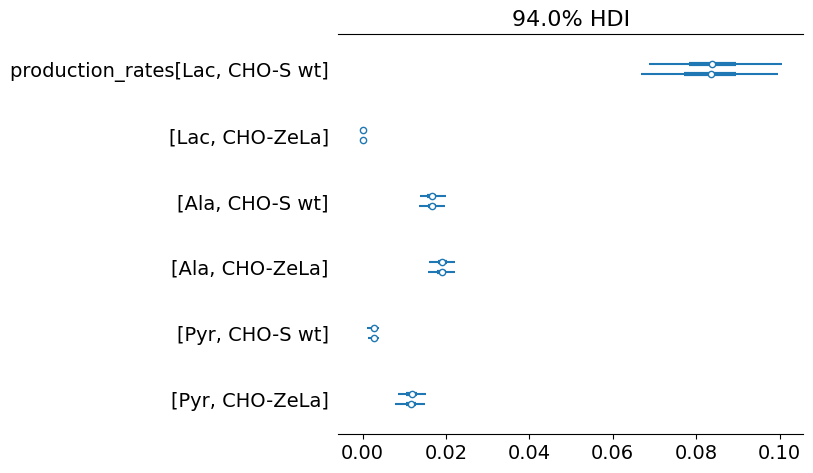

In [307]:
az.plot_forest(idata, var_names=["production_rates"])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

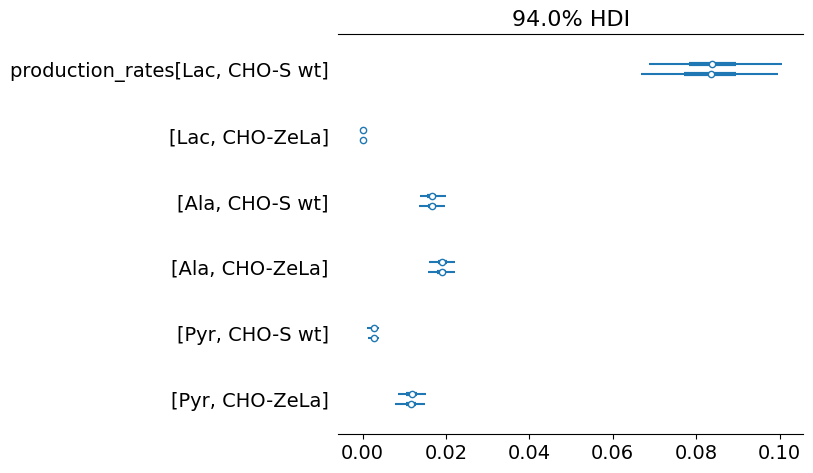

In [308]:
az.plot_forest(idata, var_names=["production_rates"])

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

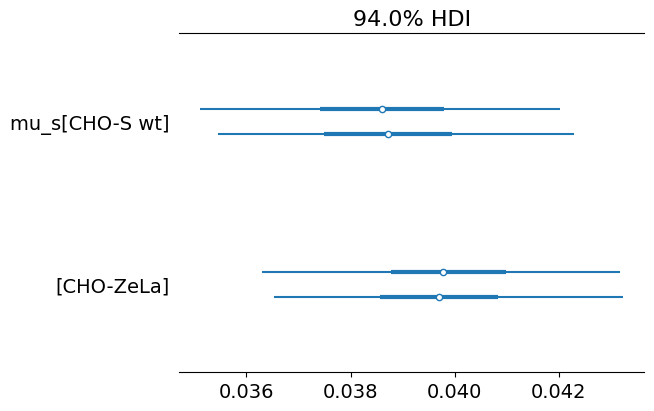

In [309]:
az.plot_forest(idata, var_names=["mu_s"])

## Using cell count
The statistical analysis from this was unsuccessful, maybe considering each component independently leads to a more robust result

In [312]:
substrates = ["Gluc"]
products = ["Lac", "Ala", "Pyr"]
model_input_cc = {
    "N_sub": len(substrates),
    "N_prod": len(products),
    "N_reactor": len(data["reactor"].unique()),
    "N_strain": len(data["strain"].unique()),
    "M": data.shape[0],
    "reactor": data["reactor"].astype(int),
    "strain":list(reactor_strain_map.values()),
    "X_m": data["ln_cell_count"],
    "S_m": data[substrates],
    "P_m": data[products],
    "t": data["time"]
}
pf_cc = model.pathfinder(
    data = model_input_cc,
    inits={
        "S_0":[[50,50,50,50,50,50,50,50]], 
        "P_0":[[20,20,20,20,20,20,20,20], [50,50,50,50,50,50,50,50], [50,50,50,50,50,50,50,50]],
    }
)
fit_cc = model.sample(
    data = model_input_cc,
    chains=2,
    inits=pf_cc.create_inits(),
    parallel_chains=2,
    iter_warmup=2000,
    iter_sampling=1000,
    max_treedepth=13,
    adapt_delta=0.999,
)
coords_cc = {
    "substrate": substrates,
    "product": products,
    "reactor": data["reactor"].astype(int).unique(),
    "strain": list(strains.values()),
    "time": data["time"],
}
dims_cc = {
    "mu": ["reactor"],
    "Ys": ["substrate", "reactor"],
    "Yp": ["product", "reactor"],
    "mu_s": ["strain"],
    "Ys_s": ["substrate", "strain"],
    "Yp_s": ["product", "strain"],
    "uptake_rates": ["substrate", "strain"],
    "production_rates": ["product", "strain"],
}
idata_cc = az.from_cmdstanpy(fit_cc, coords=coords_cc, dims=dims_cc)

23:28:05 - cmdstanpy - INFO - Chain [1] start processing
23:28:06 - cmdstanpy - INFO - Chain [1] done processing
23:28:06 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

00:06:31 - cmdstanpy - INFO - CmdStan done processing.
00:06:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 67, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 72, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 67, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 72, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 67, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 67, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 72, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 72, column 6 to column 42)
	Exception: metabolite less than zero (in 'yield_growth_rate.stan', line 72, col

## Fit was not successful
- Divergent transitions detected,
- R-hat>1.05 for many parameters,
- Max treedepth hit

These parameters suggest that the model was unable to fit, this is demonstrated by comparing the growth rates between models.

array([<AxesSubplot: title={'center': '94.0% HDI'}>], dtype=object)

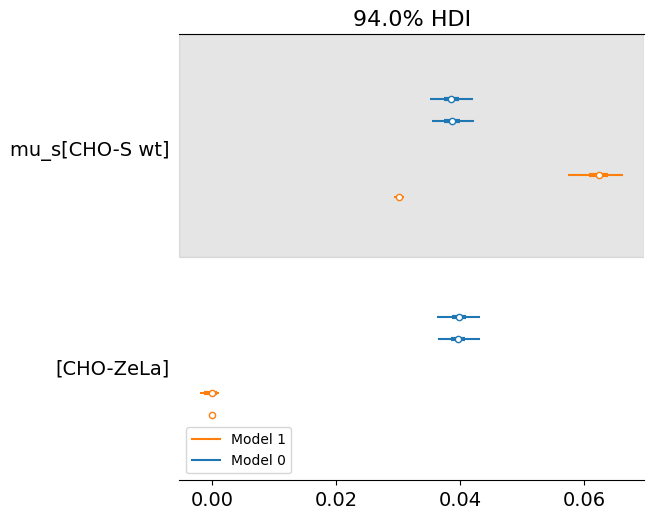

In [313]:
az.plot_forest([idata, idata_cc], var_names=["mu_s"])